In [200]:
import re
from datetime import datetime,timedelta
import numpy as np
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
from scipy import stats
from drive.MyDrive.GraduationProject.src.utils.azure_utils import AzureStorage
from moviepy.editor import AudioFileClip


In [ ]:
azure_storage_object = AzureStorage("","")

In [ ]:
blobs = azure_storage_object.list_all_blobs("tutors")
blob_names = [blob['name'] for blob in blobs if 'Coursera' in blob['name']]
blob_names[:10]

['Andrew NG/raw/text/Coursera/advanced-learning-algorithms.csv',
 'Andrew NG/raw/text/Coursera/convolutional-neural-networks.csv',
 'Andrew NG/raw/text/Coursera/deep-neural-network.csv',
 'Andrew NG/raw/text/Coursera/machine-learning-projects.csv',
 'Andrew NG/raw/text/Coursera/machine-learning.csv',
 'Andrew NG/raw/text/Coursera/neural-networks-deep-learning.csv',
 'Andrew NG/raw/text/Coursera/nlp-sequence-models.csv',
 'Andrew NG/raw/text/Coursera/unsupervised-learning-recommenders-reinforcement-learning.csv']

In [5]:
# retrieve true words for transcript (without timestamps)
true_words_dataset_path = 'Andrew NG/raw/text/Coursera/machine-learning.csv'
true_words_bytes = azure_storage_object.retrieve("tutors",true_words_dataset_path)

In [6]:
true_words_df = pd.read_csv(BytesIO(true_words_bytes))
df_copy = true_words_df.copy()
df_copy.head()

,Unnamed: 0,link,transcript
0,0,/learn/machine-learning/lecture/iYR2y/welcome-...,[MUSIC] Welcome to Machine learning. What is m...
1,1,/learn/machine-learning/lecture/IjrpM/applicat...,"In this class, you'll learn about the state of..."
2,2,/learn/machine-learning/ungradedLti/9TxpS/inta...,NaN
3,3,/learn/machine-learning/ungradedLti/q7mkB/impo...,NaN
4,4,/learn/machine-learning/lecture/PNeuX/what-is-...,"What is machine learning? In this video, you'l..."


In [7]:
df_copy = df_copy.dropna()
df_copy = df_copy.reset_index(drop=True)
print(f'Original row count {len(true_words_df)}, valid row count {len(df_copy)}')
df_copy.head()

Original row count 74, valid row count 42


,Unnamed: 0,link,transcript
0,0,/learn/machine-learning/lecture/iYR2y/welcome-...,[MUSIC] Welcome to Machine learning. What is m...
1,1,/learn/machine-learning/lecture/IjrpM/applicat...,"In this class, you'll learn about the state of..."
2,4,/learn/machine-learning/lecture/PNeuX/what-is-...,"What is machine learning? In this video, you'l..."
3,5,/learn/machine-learning/lecture/s91wX/supervis...,Machine learning is creating tremendous econom...
4,6,/learn/machine-learning/lecture/Q8Vvp/supervis...,So supervised learning algorithms learn to pre...


In [ ]:
true_words = df_copy.transcript[2]
true_words

In [151]:
# automatically captured words with time stamps (not very accurate)
subs_files_path = 'Andrew NG/raw/text/Machine Learning Specialization by Andrew Ng/3 Machine Learning Specialization Course 1 Week 1 Lesson 2.en.vtt'
file_content = azure_storage_object.retrieve("tutors",subs_files_path).decode('utf-8')
file_lines = [line for line in file_content.split("\n") if line != ""]
file_lines

['WEBVTT\n',
 'Kind: captions\n',
 'Language: en\n',
 '00:00:00.179 --> 00:00:03.409 align:start position:0%\n',
 ' \n',
 'so<00:00:01.020><c> what</c><00:00:01.500><c> is</c><00:00:01.740><c> machine</c><00:00:01.920><c> learning</c><00:00:02.460><c> in</c><00:00:03.300><c> this</c>\n',
 '00:00:03.409 --> 00:00:03.419 align:start position:0%\n',
 'so what is machine learning in this\n',
 ' \n',
 '00:00:03.419 --> 00:00:05.329 align:start position:0%\n',
 'so what is machine learning in this\n',
 'video<00:00:03.600><c> you</c><00:00:03.959><c> learn</c><00:00:04.140><c> the</c><00:00:04.380><c> definition</c><00:00:04.620><c> of</c><00:00:05.160><c> what</c>\n',
 '00:00:05.329 --> 00:00:05.339 align:start position:0%\n',
 'video you learn the definition of what\n',
 ' \n',
 '00:00:05.339 --> 00:00:08.089 align:start position:0%\n',
 'video you learn the definition of what\n',
 'it<00:00:05.520><c> is</c><00:00:05.640><c> and</c><00:00:06.359><c> also</c><00:00:06.600><c> get</c><00:00

In [ ]:
"""def getWordTimeStamps(file_content):
  content_trimmed = re.sub(r'<c>|</c>',"",file_content)
  print(content_trimmed)
  lines = re.findall(r'^[a-zA-z].*<[0-9:.]*>.*',content_trimmed,re.MULTILINE)
  #print(lines)
  words_timestamps = re.findall(r'(.*?)<(\d{2}:\d{2}:\d{2}\.\d{3})>', "\n".join(lines))
  #print(words_timestamps)
  word_timestamp_tuple = [(word,datetime.strptime(timestamp, '%H:%M:%S.%f')) for word, timestamp in words_timestamps]
  return word_timestamp_tuple"""

In [104]:
class Word:
  def __init__(self,val,time_stamp):
    self.val = val
    self.time_stamp = time_stamp
    self.delta_time = 0
class Phrase:
  def __init__(self,word=""):
    self.words = [word] if word != "" else []
    self.cut_off = None
    self.duration = 0

In [168]:
def create_words(file_lines):
  # lines detected counter
  lines_counter =0
  # remove all extra \n lines
  file_lines = [line for line in file_lines if line != "\n" ]
  word_line_pattern = "^[a-zA-z].*<[0-9:.]*>.*"
  time_stamp_pattern = '(\d{2}:\d{2}:\d{2}\.\d{3})'
  time_line_pattern = "^" + time_stamp_pattern + " -->"
  last_word_time_pattern = r'^(\d{2}:\d{2}:\d{2}\.\d{3})'
  words = []
  first_word_time_stamp = ""
  for i,line in enumerate(file_lines):
    # remove <c> and <c/c> from lines
    line_trimmed = re.sub(r'<c>',"",line)
    # if line has word-timestamp pair
    if re.match(word_line_pattern,line_trimmed):
      # increment counter
      lines_counter = lines_counter +1
      #print(line_trimmed)
      # find all words and tiem stamps pairs
      first_word = re.search("^(\S+)<",line_trimmed).group(1)
      # add first word
      words.append(Word(first_word,datetime.strptime(first_word_time_stamp, '%H:%M:%S.%f')))
      words_timestamps = re.findall(r'<(\d{2}:\d{2}:\d{2}\.\d{3})> (\S+)</c>', line_trimmed)
      # get last word (it will be isolated with no timestamp)
      #last_word = re.search("\s(\S+)$",line_trimmed).group(0)
      #print(last_word)
      # add word-timestamps pairs to list
      for timestamp, word in words_timestamps:
        words.append(Word(word,datetime.strptime(timestamp, '%H:%M:%S.%f')))
      #print(words_timestamps)
      """
      # if next line is valid
      if(i+1 < len(file_lines)):
        next_line = file_lines[i+1]
        # get last isolated word timestamp from next line
        next_line_time_stamp = re.match(last_word_time_pattern,next_line)
        if next_line_time_stamp:
          #print(next_line_time_stamp.group(0))
          words.append(Word(last_word,datetime.strptime(next_line_time_stamp.group(0), '%H:%M:%S.%f')))"""
    elif re.match(time_line_pattern,line_trimmed):
      first_word_time_stamp = re.search(time_stamp_pattern,line_trimmed).group(0)
  return words, lines_counter

In [263]:
#TODO: experiment with the word_time_diff threshold to achieve most clean data
def create_phrases(words,word_time_diff_thresh = 0.5,min_duration =3):
  initial_time = datetime(1900, 1, 1)
  word_times = []
  # initialize phrases with initial word
  phrases = [Phrase(words[0])]
  phrases_counter = 0
  for i in range(1,len(words)):
    curr_word = words[i]
    curr_time_stamp = words[i].time_stamp
    prev_time_stamp = words[i-1].time_stamp
    curr_time_diff = (curr_time_stamp-prev_time_stamp).total_seconds()
    words[i].delta_time = curr_time_diff
    word_times.append(curr_time_diff)
    if(curr_time_diff < word_time_diff_thresh or phrases[phrases_counter].duration < min_duration):
      # add word to current phrase
      phrases[phrases_counter].words.append(curr_word)
      phrases[phrases_counter].duration += curr_time_diff
    else:
      """# wait time between last spoken word and current word
      wait_time = curr_time_stamp - timedelta(seconds=curr_time_diff)
      # add it as cuttoff value
      phrases[phrases_counter].cut_off = wait_time
      if(phrases_counter > 0):
        phrases[phrases_counter].duration = (phrases[phrases_counter].cut_off - phrases[phrases_counter-1].cut_off).total_seconds()
      elif(phrases_counter == 0):
        phrases[phrases_counter].duration = (phrases[phrases_counter].cut_off - initial_time).total_seconds()
      # add full stop to current phrase
      #cut_offs[cut_offs_counter][0] = cut_offs[cut_offs_counter][0] + '.'
      """
      # add prev_time_stamp + half curr_time_diff as cuttoff value
      phrases[phrases_counter].cut_off = prev_time_stamp + timedelta(seconds=curr_time_diff/2)

       # add current word as first word in next phrase
      next_phrase = Phrase(curr_word)
      phrases.append(next_phrase)
      # increment cut_off counter
      phrases_counter = phrases_counter +1
    #print(curr_word,curr_time_diff)
  # add last phrase duration = last word time_stamp - last phrase cuttof
  #phrases[-1].duration = (phrases[-1].words[-1].time_stamp - phrases[-2].cut_off).total_seconds()
  return phrases, word_times

In [176]:
def calc_phrase_times(cut_offs):
    phrase_times = []
    for i in range(1,len(cut_offs)):
      phrase_time_diff = (cut_offs[i][1] - cut_offs[i-1][1]).total_seconds()
      phrase_times.append(phrase_time_diff)
    return phrase_times

In [177]:
def plot_hist(values,min_val =0,max_val = 10,bin_num=21,title = ""):
  values_data = np.array(values)
  bins = np.linspace(min_val, max_val, bin_num)  # Define 10 bins from 0 to 1
  hist, bin_edges = np.histogram(values_data, bins)

  # Print the histogram bin counts
  for i in range(len(hist)):
      print(f'Bin {i}: {hist[i]}')

  plt.hist(values_data, bins=bins)

  # Customize the plot (add labels and title)
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  if title != "": plt.title(title)
  plt.xlim(min_val,max_val)
  # Display the plot
  plt.show()

In [115]:
def process_true_words(true_words):
  # remove capitalization and replace - with ""
  true_words_processed = true_words.lower().replace("-","")
  true_words_list = true_words_processed.split(" ")
  true_words_list = [word for word in true_words_list if word != ""]
  return true_words_list

In [116]:
def create_true_word_sent(true_words_list):
  split_pattern = "(.*?[!;.?]+)"
  true_words_sents = re.findall(split_pattern," ".join(true_words_list))
  # remove all sentences that have have [.*] in them as they contain special sound effects
  # some examples are [inaudible], [Music]
  #filtered_true_words_sents = [true_words_sent for true_words_sent in true_words_sents if not re.search(r'\[.*\]', true_words_sent)]
  return true_words_sents

In [ ]:
words,line_count = create_words(file_lines)
true_words_list = process_true_words(true_words)
true_words_sent = create_true_word_sent(true_words_list)
true_words_sent

In [ ]:
#visualising difference
words,line_count = create_words(file_lines)
count = len(words) if len(words) > len(true_words_list) else len(true_words_list)
print("Auto\tTrue")
for i in range(count):
  auto_word = words[i].val if i < len(words) else "OUTRANGE"
  true_word = true_words_list[i] if i < len(true_words_list) else "OUTRANGE"
  print(f'{auto_word}\t{true_word}')

In [ ]:
"""true_word_idx = 0
auto_word_idx = 0
for sent in true_words_sent:
  print(sent)
  sent_words = sent.split(" ")
  #TODO: replace "-" from both texts to " " and anything to a similar effect    (DONE)

  for true_word in sent_words:
    auto_word = word_timestamp_tuple[auto_word_idx][0]
    # remove capitalization and replace - with " "
    auto_word = auto_word.lower().replace("-","")
    print(auto_word)
    # split word to list to check for word-word-... pattern
    auto_word_list = [word for word in auto_word.split(" ") if word != ""]
    for i in range(len(auto_word_list)):
      curr_auto_word= auto_word_list[i]
      # if current_auto_word isn't equal to current true word in sentence
      if(curr_auto_word != true_word):
        # get next auto word from list if possible otherwise from array
        next_auto_word = word_timestamp_tuple[auto_word_idx+1][0] if i+1 >= len(auto_word_list) else auto_word_list[i+1]
        # if next auto word is equal curretn true word then current auto_word is completely inserted
        if(next_auto_word  == true_word):
            print(next_auto_word,true_word)
            # increment auto_word_idx if necessary
            auto_word_idx = auto_word_idx+1 if  i+1 >= len(auto_word_list) else auto_word_idx
            #true_word_idx += 1
      print(word_timestamp_tuple[auto_word_idx][0] +"\t" + true_word)
    auto_word_idx += 1
  break"""

In [ ]:
#TODO: mix coursera transcript punctuation with youtube transcript strings
# NOT Completed
true_word_idx = 0
auto_word_idx = 0
for sent in true_words_sent:
  print(sent)
  sent_words = [word for word in sent.split(" ") if word != ""]
  for true_word in sent_words:
    auto_word = words[auto_word_idx][0]
    # remove capitalization and replace - with " "
    curr_auto_word = auto_word.lower().replace("-","")
    # if current_auto_word isn't equal to current true word in sentence
    if(curr_auto_word != true_word):
      # get next auto word from list
      next_auto_word = words[auto_word_idx+1][0]
      next_auto_word = ""
      # if next auto word is equal curretn true word then current auto_word is completely inserted
      if(next_auto_word  == true_word):
          # increment auto_word_idx
          auto_word_idx = auto_word_idx+1
    print(words[auto_word_idx][0] +"\t" + true_word)
    auto_word_idx += 1
    true_word_idx += 1


word diff Threshold 0.5
sentence count 135
Phrase time summary DescribeResult(nobs=66, minmax=(3.66, 10.019), mean=4.959090909090908, variance=1.289505283916084, skewness=1.8675082110617351, kurtosis=5.094315666810537)
Phrase time kt test p-value 0.0
word diff Threshold 0.55
sentence count 135
Phrase time summary DescribeResult(nobs=60, minmax=(3.72, 11.039), mean=5.454999999999999, variance=2.7362176271186436, skewness=1.4476564799822982, kurtosis=1.804493186064306)
Phrase time kt test p-value 0.0
word diff Threshold 0.6
sentence count 135
Phrase time summary DescribeResult(nobs=58, minmax=(3.72, 10.019), mean=5.643103448275863, variance=2.321020024198427, skewness=0.8382335943117684, kurtosis=0.08558705064486771)
Phrase time kt test p-value 0.0
word diff Threshold 0.65
sentence count 135
Phrase time summary DescribeResult(nobs=52, minmax=(3.72, 12.78), mean=6.294230769230769, variance=4.122902102564101, skewness=0.9412559712632576, kurtosis=0.5854935693267667)
Phrase time kt test p-v

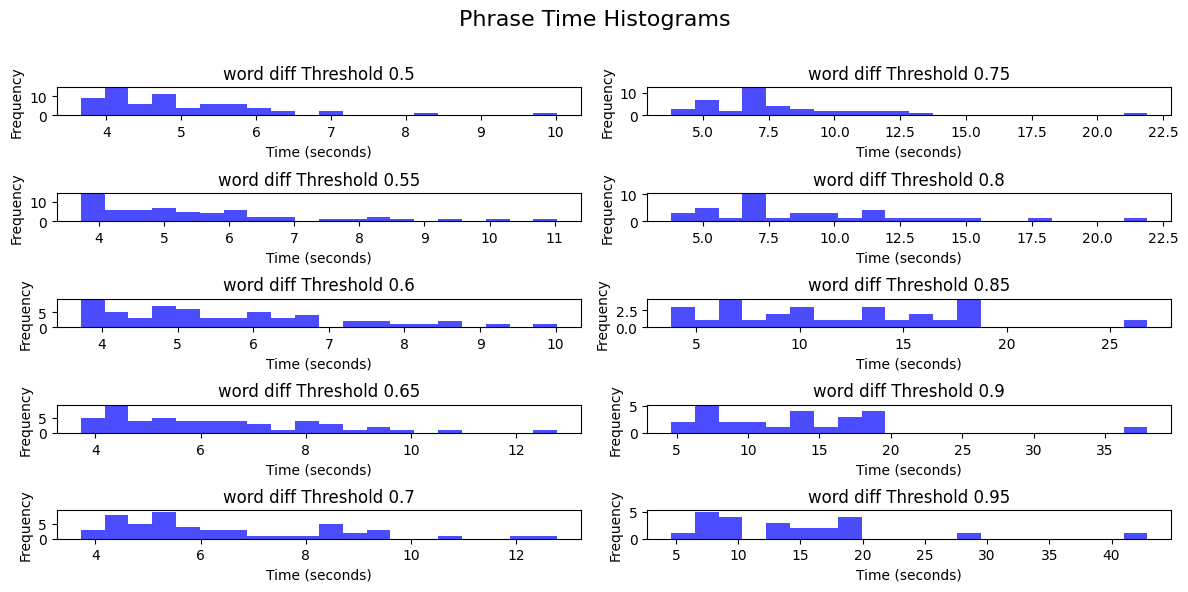

In [186]:
fig, axes = plt.subplots(5, 2, figsize=(12, 6))
fig.suptitle("Phrase Time Histograms", fontsize=16)
# TODO: Filter best word diff threshold based on minimizing kstest with uniform distribution
for i in range(10,20):
  word_diff_thresh =  + i/20
  idx2 = 0 if i < 15 else 1
  ax = axes[i % 5,idx2]
  ax.set_title('word diff Threshold ' + str(word_diff_thresh))
  print( 'word diff Threshold '+ str(word_diff_thresh))
  words,line_count = create_words(file_lines)
  print('sentence count ' + str(line_count))
  phrases, word_times = create_phrases(words,word_diff_thresh)
  #print('Cutoff time summary' + stats.describe(cutoffs))
  phrase_times = [phrase.duration for phrase in phrases]
  print('Phrase time summary',stats.describe(phrase_times))
  kt_test_result , p_val = stats.kstest(phrase_times, 'uniform')
  print('Phrase time kt test p-value',p_val)
  ax.hist(phrase_times, bins=20, color='blue', alpha=0.7)
  ax.set_xlabel('Time (seconds)')
  ax.set_ylabel('Frequency')
# Adjust the layout for better spacing
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show the subplots
plt.show()
  #plot_hist(phrase_times,title="Phrase Time Histogram")

In [269]:
# using 0.65 as threshold
words,line_count = create_words(file_lines)
phrases, word_times = create_phrases(words,0.65,2)

Bin 0: 271
Bin 1: 321
Bin 2: 174
Bin 3: 70
Bin 4: 22
Bin 5: 16
Bin 6: 6
Bin 7: 1
Bin 8: 1
Bin 9: 0


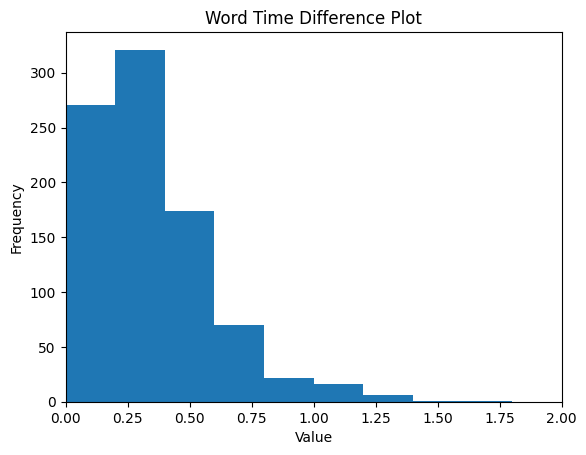

In [223]:
word_time_data = np.array(word_times)
bins = np.linspace(0, 2, 11)  # Define 10 bins from 0 to 1
hist, bin_edges = np.histogram(word_time_data, bins)

# Print the histogram bin counts
for i in range(len(hist)):
    print(f'Bin {i}: {hist[i]}')

plt.hist(word_time_data, bins=bins)

# Customize the plot (add labels and title)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Word Time Difference Plot')
plt.xlim(0,2)
# Display the plot
plt.show()

In [217]:
raw_path = 'data/raw/audio/Machine Learning Specialization by Andrew Ng/3 Machine Learning Specialization Course 1 Week 1 Lesson 2.mp4'
raw_path_list = raw_path.split('/')
processed_path = raw_path_list[0] + '/processed/audio/Machine Learning Specialization by Andrew Ng'
print(raw_path + '\n' +processed_path)

data/raw/audio/Machine Learning Specialization by Andrew Ng/3 Machine Learning Specialization Course 1 Week 1 Lesson 2.mp4
data/processed/audio/Machine Learning Specialization by Andrew Ng


In [276]:
for i,phrase in enumerate(phrases):
  print([[word.val,word.time_stamp,word.delta_time] for word in phrase.words],phrase.cut_off)
  if(i==2): break

[['so', datetime.datetime(1900, 1, 1, 0, 0, 0, 179000), 0], ['what', datetime.datetime(1900, 1, 1, 0, 0, 1, 20000), 0.841], ['is', datetime.datetime(1900, 1, 1, 0, 0, 1, 500000), 0.48], ['machine', datetime.datetime(1900, 1, 1, 0, 0, 1, 740000), 0.24], ['learning', datetime.datetime(1900, 1, 1, 0, 0, 1, 920000), 0.18], ['in', datetime.datetime(1900, 1, 1, 0, 0, 2, 460000), 0.54]] 1900-01-01 00:00:03.020000
[['this', datetime.datetime(1900, 1, 1, 0, 0, 3, 300000), 0.84], ['video', datetime.datetime(1900, 1, 1, 0, 0, 3, 419000), 0.119], ['you', datetime.datetime(1900, 1, 1, 0, 0, 3, 600000), 0.181], ['learn', datetime.datetime(1900, 1, 1, 0, 0, 3, 959000), 0.359], ['the', datetime.datetime(1900, 1, 1, 0, 0, 4, 140000), 0.181], ['definition', datetime.datetime(1900, 1, 1, 0, 0, 4, 380000), 0.24], ['of', datetime.datetime(1900, 1, 1, 0, 0, 4, 620000), 0.24], ['what', datetime.datetime(1900, 1, 1, 0, 0, 5, 160000), 0.54], ['it', datetime.datetime(1900, 1, 1, 0, 0, 5, 339000), 0.179], ['is',

In [266]:
# Testing audio with youtube time stamps fails
audio = AudioFileClip(raw_path)
start_time = '0'
end_time = phrases[0].cut_off.strftime('%H:%M:%S.%f')
cut_audio = audio.subclip(start_time, end_time)
# make sure that folder exsist before hand
processed_audio_path = processed_path + "/audio1.wav"
cut_audio.write_audiofile(processed_audio_path)

MoviePy - Writing audio in data/processed/audio/Machine Learning Specialization by Andrew Ng/audio1.wav


MoviePy - Done.
